In [65]:
import numpy as np
import pandas as pd
import yfinance as yf

In [66]:
stock_symbol = 'TATAMOTORS.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [67]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1991-01-02,20.959597,21.857864,20.959597,21.857864,15.738645,0
1991-01-03,20.959597,21.857864,20.959597,21.857864,15.738645,0
1991-01-04,21.857864,21.857864,21.857864,21.857864,15.738645,0
1991-01-07,20.360750,21.259020,20.061329,21.109308,15.199643,0
1991-01-08,21.109308,21.109308,21.109308,21.109308,15.199643,0
...,...,...,...,...,...,...
2024-04-25,992.500000,1003.299988,989.500000,1001.250000,1001.250000,8366455
2024-04-26,1007.799988,1008.950012,996.599976,999.500000,999.500000,7937500
2024-04-29,1003.049988,1005.750000,999.000000,1000.599976,1000.599976,4764750


In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [69]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [70]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [71]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
262/262 [==============================] - 9s 14ms/step - loss: 0.0020
Epoch 2/50
262/262 [==============================] - 4s 16ms/step - loss: 7.2363e-04
Epoch 3/50
262/262 [==============================] - 6s 24ms/step - loss: 6.6145e-04
Epoch 4/50
262/262 [==============================] - 5s 18ms/step - loss: 5.3064e-04
Epoch 5/50
262/262 [==============================] - 3s 12ms/step - loss: 4.9651e-04
Epoch 6/50
262/262 [==============================] - 3s 12ms/step - loss: 4.6684e-04
Epoch 7/50
262/262 [==============================] - 4s 14ms/step - loss: 5.0658e-04
Epoch 8/50
262/262 [==============================] - 3s 12ms/step - loss: 4.7982e-04
Epoch 9/50
262/262 [==============================] - 3s 12ms/step - loss: 4.1159e-04
Epoch 10/50
262/262 [==============================] - 3s 12ms/step - loss: 4.3737e-04
Epoch 11/50
262/262 [==============================] - 4s 14ms/step - loss: 3.7882e-04
Epoch 12/50
262/262 [==============================] - 3

1/1 [==============================] - 0s 41ms/step


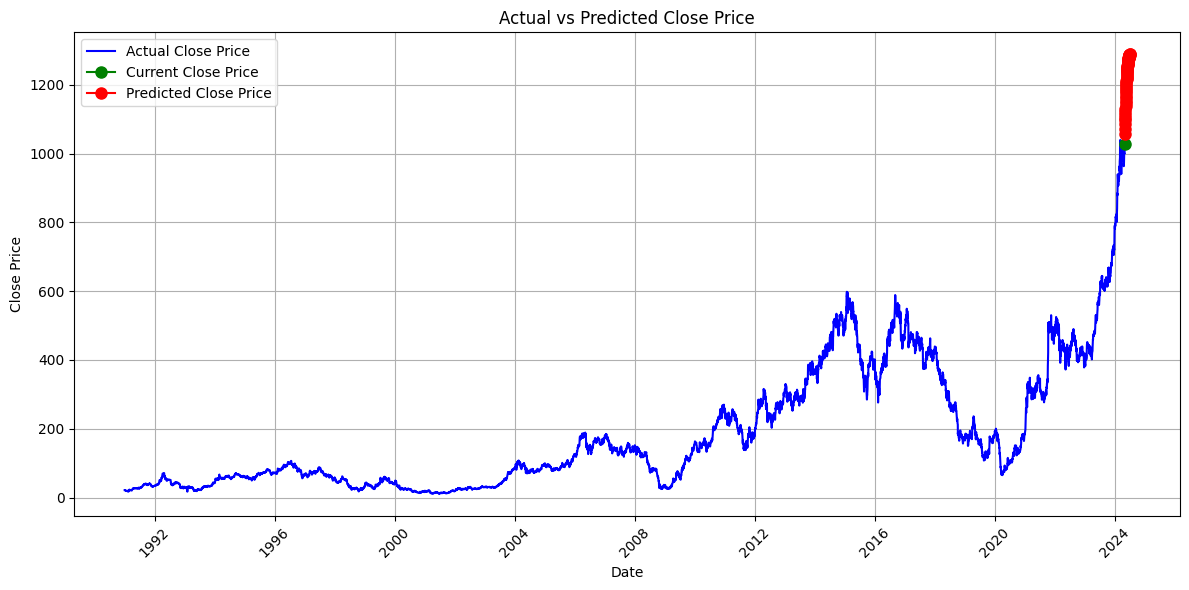

In [72]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
predicted_prices

array([1055.8091, 1072.5925, 1086.2611, 1096.1268, 1103.9911, 1111.7358,
       1120.0868, 1128.8474, 1137.5458, 1145.8752, 1153.7725, 1161.3005,
       1168.5269, 1175.4736, 1182.1306, 1188.4827, 1194.5261, 1200.2687,
       1205.7227, 1210.8998, 1215.8097, 1220.4608, 1224.8624, 1229.024 ,
       1232.9558, 1236.6683, 1240.1718, 1243.4758, 1246.5901, 1249.5243,
       1252.2875, 1254.8889, 1257.3367, 1259.6396, 1261.8055, 1263.8418,
       1265.756 , 1267.5549, 1269.2452, 1270.8331, 1272.3247, 1273.7253,
       1275.0405, 1276.2754, 1277.4346, 1278.5227, 1279.5441, 1280.5027,
       1281.4021, 1282.2461, 1283.038 , 1283.781 , 1284.4779, 1285.132 ,
       1285.7455, 1286.3209, 1286.8608, 1287.3672, 1287.8422, 1288.2878],
      dtype=float32)

In [75]:
model.save('TATAMOTORS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
import joblib
joblib.dump(scaler, 'TATAMOTORS_minmax_scaler.pkl')

['TATAMOTORS_minmax_scaler.pkl']